# Digit Recognizer

In this notebook, I am experimenting with the MNIST dataset for the Kaggle competition [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer). In particular, I am using this dataset as an opportunity to try out [Tensorflow's high level Python API](https://www.tensorflow.org/get_started/premade_estimators) to generate a deep neural network and I compare its performance with some other popular classification approaches. 
Furthermore, I came back to this notebook some time later to explore a different path for building deep neural networks using [Keras](https://keras.io/), a very popular high-level neural networks API, written in Python and capable of running on top of Deep Learning libraries like TensorFlow.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Data preparation

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
# splitting features and labels
X_train = train.drop("label", axis=1)
y_train = train["label"]
del train # freeing memory

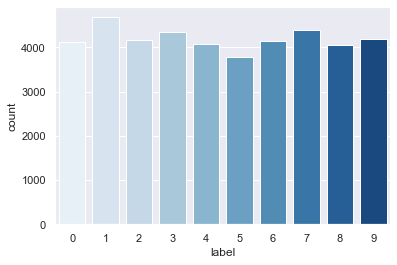

In [4]:
g = sns.countplot(y_train, palette='Blues')

Great, the distribution of training samples is approximately uniform, which is an important prerequisite.

## Modeling: Common sklearn classifiers

In the following, I will use use 6-fold cross validation evaluate five well-knowns classification algorithms for the MNIST dataset.

In [5]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

In [6]:
classifiers = []
classifiers.append(DecisionTreeClassifier(min_samples_leaf=5, random_state=12))
classifiers.append(KNeighborsClassifier(n_neighbors=5))
classifiers.append(GaussianNB())
classifiers.append(QuadraticDiscriminantAnalysis())
classifiers.append(RandomForestClassifier(n_estimators=200, random_state=12))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", cv=6, n_jobs=3, verbose=2))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   20.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed: 14.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:    4.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:   24.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:  1.8min finished


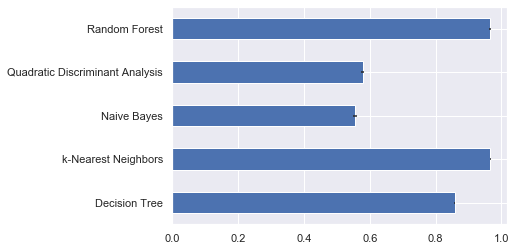

In [7]:
names = ['Decision Tree', 'k-Nearest Neighbors', 'Naive Bayes', 'Quadratic Discriminant Analysis', 'Random Forest']
    
cv_res = pd.DataFrame({'name': names, 'mean': cv_means, 'std': cv_std})
cv_res.plot(kind='barh', x='name', y='mean', xerr='std', legend=False)
plt.ylabel('')
plt.show()

The results above are certainly not astonishing. Of course, a lot could be improved by tuning hyperparameters, but that is outside the scope of this notebook. 

However, the k-nearest neighbors and Random Forest approaches give a pretty decent accuracy score. For this reason, I will use both approaches later to compare their Kaggle test score with the one of the Tensorflow deep neural network. 

In [8]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [9]:
print('KNN training accuracy:', accuracy_score(y_train, knn.predict(X_train)))

KNN training accuracy: 0.9791428571428571


In [10]:
def save_prediction(predictions, prefix):
    ids = pd.Series(range(1,28001),name = "ImageId")
    pred = pd.Series(predictions, name="Label").astype(int)
    submission = pd.concat([ids, pred],axis=1)
    submission.to_csv(prefix + '_submission.csv', index=False)

knn_predictions = knn.predict(test)
save_prediction(knn_predictions, 'knn')

The model scored 96,8% accuracy on the Kaggle test set, good! Now I already have a first benchmark for upcoming deep neural networks. Next comes the Random Forest classifier.

In [11]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
print('Random Forest training accuracy:', accuracy_score(y_train, rf.predict(X_train)))

Random Forest training accuracy: 1.0


Quite obviously, the Reandom Forest classifier massively overfits to the training data without cross validation. As training The model was possible in reasonable time, I will attempt some hypterparameter tuning to improve this.

In [12]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'max_depth': [5, 10, 15, 20], 'max_features': ['auto', 'sqrt'], 
              'min_samples_leaf': [2, 3, 5], 'min_samples_split': [4, 6, 10], 
              'n_estimators': [100, 200, 400]}

rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions = param_grid, 
                               n_iter = 50, cv = 3, verbose=2, random_state=12, scoring='accuracy', n_jobs = -1)
rf_random.fit(X_train, y_train)

print('Best accuracy score:', rf_random.best_score_)
print('Best parameters:', rf_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 23.5min finished


Best accuracy score: 0.9613333333333333
Best parameters: {'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20}


In [14]:
# Generate prediction from best estimator
rf_predictions = rf_random.best_estimator_.predict(test)
save_prediction(rf_predictions, 'rf')

The model scored 96,5% accuracy on the Kaggle test set, great! This provides another good benchmark for subsequent Deep Learning approaches!

## Modeling: Tensorflow Deep Neural Network Classifier

Now, I will proceed to build a deep neural network with Tensorflow! After experimenting with a few parameters, I eventually decided to train the model with a dropout of 0.05, a batch size of 50 and 500 epochs (one epoch corresponds to traversing the entire training data once).

In [15]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # to disable Tensorflow's extensive INFO messages.

In [16]:
feature_columns = [tf.feature_column.numeric_column("x", shape=[784])]
train_input_tf = tf.compat.v1.estimator.inputs.numpy_input_fn(x={'x': X_train.values},  y=y_train, 
                                                              num_epochs=500, batch_size=50, shuffle=True)
test_input_tf = tf.compat.v1.estimator.inputs.numpy_input_fn(x={'x': X_train.values},  y=y_train, 
                                                             num_epochs=1, shuffle=False)
pred_input_tf = tf.compat.v1.estimator.inputs.numpy_input_fn(x={'x': test.values}, 
                                                             num_epochs=1, shuffle=False)

In [17]:
dnn = tf.compat.v1.estimator.DNNClassifier(feature_columns=feature_columns, 
                                           hidden_units=[128, 32], n_classes=10, dropout=0.05)

pred_dnn = {} # to save intermediate prediction results

print("Training the DNN classifier for 500 epochs:")
for i in range(10):
    dnn.train(input_fn=train_input_tf, steps=42000) # 84000 corresponds to 100 epochs (42000 samples / batch_size)
    score = dnn.evaluate(input_fn=test_input_tf)
    print("DNN accuracy ({} epochs: {}".format(50*(i+1), score))
    dnn_test_results = dnn.predict(input_fn=pred_input_tf)
    pred_dnn[i] = [r for r in dnn_test_results]

Training the DNN classifier for 500 epochs:
DNN accuracy (50 epochs: {'accuracy': 0.9410238, 'average_loss': 0.26284668, 'loss': 33.554893, 'global_step': 42000}
DNN accuracy (100 epochs: {'accuracy': 0.98702383, 'average_loss': 0.046676774, 'loss': 5.958737, 'global_step': 84000}
DNN accuracy (150 epochs: {'accuracy': 0.99430954, 'average_loss': 0.02092529, 'loss': 2.6713138, 'global_step': 126000}
DNN accuracy (200 epochs: {'accuracy': 0.99640477, 'average_loss': 0.014479594, 'loss': 1.8484588, 'global_step': 168000}
DNN accuracy (250 epochs: {'accuracy': 0.9975476, 'average_loss': 0.011065093, 'loss': 1.4125651, 'global_step': 210000}
DNN accuracy (300 epochs: {'accuracy': 0.99811906, 'average_loss': 0.008507977, 'loss': 1.0861248, 'global_step': 252000}
DNN accuracy (350 epochs: {'accuracy': 0.99838096, 'average_loss': 0.007358469, 'loss': 0.93937904, 'global_step': 294000}
DNN accuracy (400 epochs: {'accuracy': 0.99857146, 'average_loss': 0.0061754934, 'loss': 0.7883609, 'global_s

Wow, 99,69 % accuracy, not bad at all! However, this suggest that the DNN might also be overfitting to the training data. Time to make predictions for the Kaggle test data:

In [18]:
pred_input_tf = tf.compat.v1.estimator.inputs.numpy_input_fn(x={'x': test.values}, num_epochs=1, shuffle=False)
dnn_test_results = dnn.predict(input_fn=pred_input_tf)
dnn_predictions = np.array([np.argmax(r['probabilities']) for r in dnn_test_results])
save_prediction(dnn_predictions, 'dnn')

The model scored 95,84% at the Kaggle competition. This is not bad, but also below the score achieved by the KNN classifier. Definitely, the model is not trained ideally. However, I consider this a success for a first experiment with a Tensorflow DNN and will leave a more elaborate examination with neural networks as future work for myself.

Nonetheless, I want to take a last step and try to improve the Kaggle test score by combining the intermediate predictions that I had saved while training above after each pack of 50 epochs:

In [19]:
dnn_probabilities = np.array([[r['probabilities'] for r in pred_dnn[i]] for i in range(10)])
dnn_combined_proba = np.sum(p for p in dnn_probabilities)/10
dnn_combined_predictions = np.array([np.argmax(r) for r in dnn_combined_proba])
save_prediction(dnn_combined_predictions, 'dnn_combined')

The resulting accuracy on the Kaggle test set was 96,21%! Still not as good as the KNN classifier, but at least an improvement. Definitely, building and training neural networks is a topic that I will look into deeper in the future!

## Modeling: Deep Neural Networks with Keras

Some time after creating the preceeding parts of this notebook, I am coming back for building more DNNs for the MNIST dataset using [Keras](https://keras.io/). First, I will create a network with three hidden Dense layers. Afterwards, I will create a convolutional neural network (CNN) with convolutional and pooling layers, which are known to be very effective for images. The concrete network architecture of the CNN I will use has been inspired by a blog post I have read about CNNs.

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [23]:
# Prepare data
features = X_train
n_cols = features.shape[1]
target = to_categorical(y_train, num_classes = 10)

In [24]:
# Create first Dense model with three hidden layers
dense_model = Sequential()
dense_model.add(Dense(256, activation='relu', input_shape = (n_cols,)))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dense(64, activation='relu'))
dense_model.add(Dropout(0.25))
dense_model.add(Dense(10, activation='softmax'))
dense_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compile and fit the model
dense_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=10)
dense_model_training = dense_model.fit(features, target, validation_split=0.25, epochs=200, callbacks=[early_stopping_monitor])

Train on 31500 samples, validate on 10500 samples
Epoch 1/200
31500/31500 [==============================] - 4s 139us/step - loss: 1.7716 - accuracy: 0.6209 - val_loss: 0.7728 - val_accuracy: 0.7770
Epoch 2/200
31500/31500 [==============================] - 4s 133us/step - loss: 0.6739 - accuracy: 0.7983 - val_loss: 0.4101 - val_accuracy: 0.9057
Epoch 3/200
31500/31500 [==============================] - 4s 134us/step - loss: 0.5013 - accuracy: 0.8597 - val_loss: 0.3198 - val_accuracy: 0.9225
Epoch 4/200
31500/31500 [==============================] - 4s 133us/step - loss: 0.3674 - accuracy: 0.8955 - val_loss: 0.2902 - val_accuracy: 0.9270
Epoch 5/200
31500/31500 [==============================] - 4s 134us/step - loss: 0.3015 - accuracy: 0.9145 - val_loss: 0.2752 - val_accuracy: 0.9450
Epoch 6/200
31500/31500 [==============================] - 4s 136us/step - loss: 0.2610 - accuracy: 0.9290 - val_loss: 0.2558 - val_accuracy: 0.9487
Epoch 7/200
31500/31500 [==============================]

In [35]:
# Predict for the test set and save predictions
dense_model_predictions = np.array([np.argmax(r) for r in dense_model.predict(test)])
save_prediction(dense_model_predictions, 'dense_model')

The dense model scored 96,64% on Kaggle, nice! Let's see next how the NCC model performs.

In [27]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
features_reshaped = X_train.values.reshape(-1,28,28,1)
test_reshaped = test.values.reshape(-1,28,28,1)

In [28]:
# Create Convolutional Neural Network model with two convolution+pooling blocks
cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
cnn_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation = "relu"))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(10, activation = "softmax"))

cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [29]:
# Compile and fit the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=10)
cnn_model_training = cnn_model.fit(features_reshaped, target, validation_split=0.25, epochs=200, callbacks=[early_stopping_monitor])

Train on 31500 samples, validate on 10500 samples
Epoch 1/200
31500/31500 [==============================] - 118s 4ms/step - loss: 0.3963 - accuracy: 0.8917 - val_loss: 0.0744 - val_accuracy: 0.9780
Epoch 2/200
31500/31500 [==============================] - 118s 4ms/step - loss: 0.1170 - accuracy: 0.9675 - val_loss: 0.0505 - val_accuracy: 0.9852
Epoch 3/200
31500/31500 [==============================] - 116s 4ms/step - loss: 0.0916 - accuracy: 0.9745 - val_loss: 0.0565 - val_accuracy: 0.9825
Epoch 4/200
31500/31500 [==============================] - 115s 4ms/step - loss: 0.0788 - accuracy: 0.9779 - val_loss: 0.0374 - val_accuracy: 0.9894
Epoch 5/200
31500/31500 [==============================] - 116s 4ms/step - loss: 0.0685 - accuracy: 0.9811 - val_loss: 0.0566 - val_accuracy: 0.9845
Epoch 6/200
31500/31500 [==============================] - 115s 4ms/step - loss: 0.0654 - accuracy: 0.9822 - val_loss: 0.0542 - val_accuracy: 0.9854
Epoch 7/200
31500/31500 [==============================]

99% validation accuracy after just 15 epochs, wow. Let's compare the training progress of the dense model and CNN model:

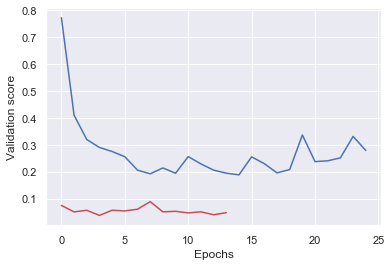

In [30]:
# Create the plot
plt.plot(dense_model_training.history['val_loss'], 'b', cnn_model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

It really looks like the training scores of CNN model outperform the scores of the dense model by far. Finally, let's submit the predictions 

In [36]:
# Predict for the test set and save predictions
cnn_model_predictions = np.array([np.argmax(r) for r in cnn_model.predict(test_reshaped)])
save_prediction(cnn_model_predictions, 'cnn_model')

We have a winner! The CNN model scored 98,71% on Kaggle and was therefore able to maintain its training performance. Overall, this is not surprising as convolutional neural networks are well-known these days to excel for image classification tasks.